In [86]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
file = 'Dataset-Kickstarter-projects-2018.csv'
if file in os.listdir():
    print(f'Encontramos o arquivo {file}, podemos prosseguir!')
else:
    print(f'Não encontramos o arquivo {file} no diretório {os.getcwd()}!')

Encontramos o arquivo Dataset-Kickstarter-projects-2018.csv, podemos prosseguir!


In [88]:
dataset = pd.read_csv(file)
dataset.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [89]:
dataset['main_category'] = dataset.loc[:,'main_category'].astype('category')
dataset['currency'] = dataset.loc[:,'currency'].astype('category')
dataset['deadline'] = dataset.loc[:,'deadline'].astype('datetime64')
dataset['launched'] = dataset.loc[:,'launched'].astype('datetime64')
dataset['state'] = dataset.loc[:,'state'].astype('category')
dataset['country'] = dataset.loc[:,'country'].astype('category')

dataset.dtypes

ID                           int64
name                        object
category                    object
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                     category
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

In [90]:
dataset['launched_Dates'] = pd.to_datetime(dataset['launched']).dt.date

dataset['launched_Year'] = pd.to_datetime(dataset['launched']).dt.year

dataset['launched_Month'] = pd.to_datetime(dataset['launched']).dt.month

dataset['deadline'] = pd.to_datetime(dataset['deadline']).dt.date

dataset['delta_time'] = dataset['deadline'] - dataset['launched_Dates']

dataset = dataset.drop(columns = ['ID', 'currency', 'pledged', 'usd pledged', 'category', 'launched', 'deadline', 'backers', 'launched_Dates'])

In [91]:
filtra_sucesso = dataset['state'] == 'successful'
filtra_falha = dataset['state'] == 'failed'
dataset = dataset.loc[(filtra_sucesso | filtra_falha),:]
dataset

,name,main_category,goal,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,The Songs of Adelaide & Abullah,Publishing,1000.0,failed,GB,0.0,1533.95,2015,8,59 days
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,30000.0,failed,US,2421.0,30000.00,2017,9,60 days
2,Where is Hank?,Film & Video,45000.0,failed,US,220.0,45000.00,2013,1,45 days
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,5000.0,failed,US,1.0,5000.00,2012,3,30 days
5,Monarch Espresso Bar,Food,50000.0,successful,US,52375.0,50000.00,2016,2,35 days
...,...,...,...,...,...,...,...,...,...,...
378654,"Homemade fresh dog food, Cleveland OH",Food,6500.0,failed,US,154.0,6500.00,2017,3,30 days
378657,The Tribe,Film & Video,1500.0,failed,US,155.0,1500.00,2011,6,27 days
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Film & Video,15000.0,failed,US,20.0,15000.00,2010,7,46 days
378659,BioDefense Education Kit,Technology,15000.0,failed,US,200.0,15000.00,2016,1,31 days


In [92]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english') 

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[!-.:?;"\n"()''"",_%$\|/,<>]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    
    texto_limpo = []
    
    for w in w_tokenizer.tokenize(text_subbed):
        palavra_limpa = lemmatizer.lemmatize(w)
        texto_limpo.append(palavra_limpa)
        
    
    return texto_limpo

In [93]:
dataset['name'] = dataset['name'].astype('str')
dataset['name'] = dataset['name'].apply(cleanup)

In [94]:
dataset

,name,main_category,goal,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,"[The, Songs, of, Adelaide, Abullah]",Publishing,1000.0,failed,GB,0.0,1533.95,2015,8,59 days
1,"[Greeting, From, Earth, ZGAC, Arts, Capsule, F...",Film & Video,30000.0,failed,US,2421.0,30000.00,2017,9,60 days
2,"[Where, is, Hank]",Film & Video,45000.0,failed,US,220.0,45000.00,2013,1,45 days
3,"[ToshiCapital, Rekordz, Needs, Help, to, Compl...",Music,5000.0,failed,US,1.0,5000.00,2012,3,30 days
5,"[Monarch, Espresso, Bar]",Food,50000.0,successful,US,52375.0,50000.00,2016,2,35 days
...,...,...,...,...,...,...,...,...,...,...
378654,"[Homemade, fresh, dog, food, Cleveland, OH]",Food,6500.0,failed,US,154.0,6500.00,2017,3,30 days
378657,"[The, Tribe]",Film & Video,1500.0,failed,US,155.0,1500.00,2011,6,27 days
378658,"[Walls, of, Remedy, New, lesbian, Romantic, Co...",Film & Video,15000.0,failed,US,20.0,15000.00,2010,7,46 days
378659,"[BioDefense, Education, Kit]",Technology,15000.0,failed,US,200.0,15000.00,2016,1,31 days


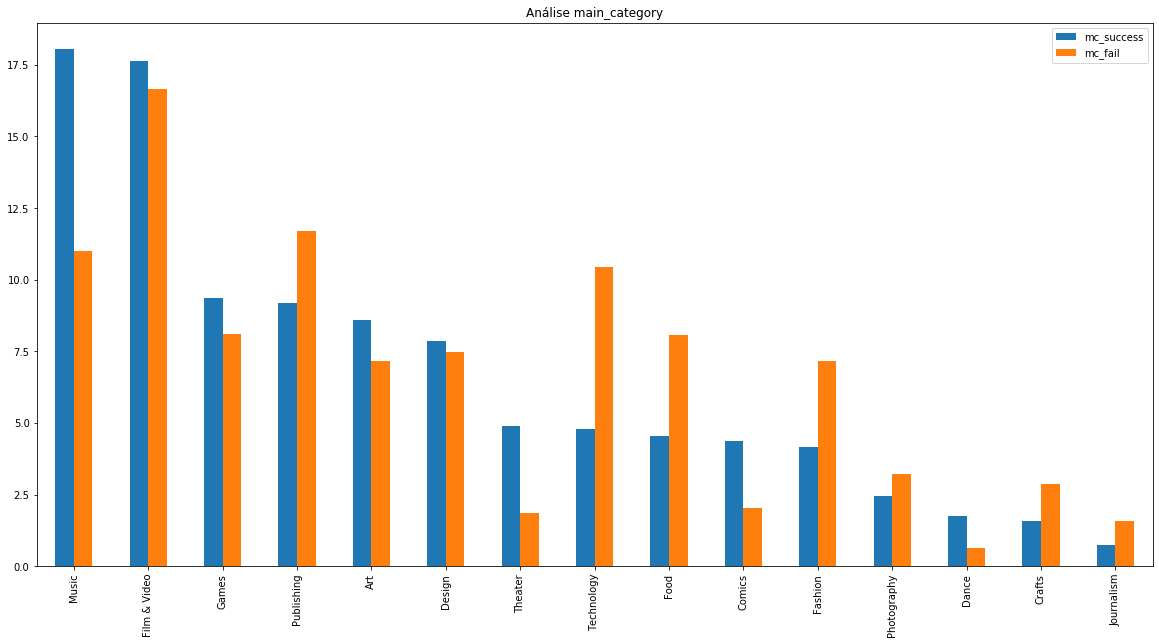

In [95]:
mc = pd.DataFrame()
mc['mc_success'] = dataset.loc[filtra_sucesso,'main_category'].value_counts(normalize = 'index')*100
mc['mc_fail'] = dataset.loc[filtra_falha,'main_category'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mc = mc.plot.bar(ax = ax1, title = 'Análise main_category')

In [96]:
pd.crosstab(dataset.main_category, dataset.state, normalize = 'index', margins = True)*100

state,failed,successful
main_category,,
Art,55.110955,44.889045
Comics,40.858473,59.141527
Crafts,72.947045,27.052955
Dance,34.564791,65.435209
Design,58.405614,41.594386
Fashion,71.716814,28.283186
Film & Video,58.209351,41.790649
Food,72.408633,27.591367
Games,56.109533,43.890467


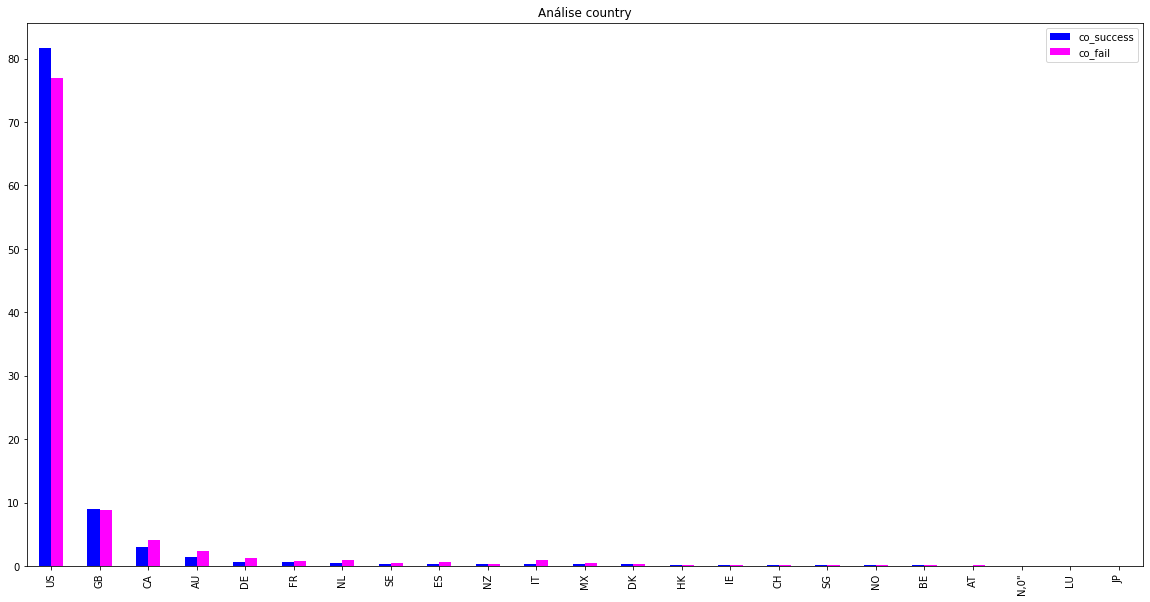

In [97]:
co = pd.DataFrame()
co['co_success'] = dataset.loc[filtra_sucesso,'country'].value_counts(normalize = 'index')*100
co['co_fail'] = dataset.loc[filtra_falha,'country'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_co = co.plot.bar(ax = ax1, title = 'Análise country', color = ['blue', 'magenta'])

In [98]:
pd.crosstab(dataset.country, dataset.state, normalize = True)*100

state,failed,successful
country,,
AT,0.113967,0.032260
AU,1.388709,0.606015
BE,0.111856,0.045828
CA,2.483154,1.246401
CH,0.140197,0.056380
DE,0.753448,0.282505
DK,0.170649,0.108540
ES,0.416371,0.148338
FR,0.486018,0.273762


In [10]:
train, test = train_test_split(dataset, test_size=0.2)

In [ ]:
train_limpo'